In [1]:
import torch
import torch.nn.functional as F
from pathlib import Path
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import tifffile as tiff
import cv2

In [2]:
data_path = Path("../data/")
os.listdir(data_path)

['train_images',
 'test_images',
 'train_annotations',
 'train.csv',
 'sample_submission.csv',
 'test.csv']

In [3]:
train_images_path = data_path / "train_images"

In [4]:
train_df = pd.read_csv(data_path / "train.csv")
train_df['path'] = train_df.id.apply(lambda x: f'{str(train_images_path)}/{x}.tiff')
train_df.head()

,id,organ,data_source,img_height,img_width,pixel_size,tissue_thickness,rle,age,sex,path
0,10044,prostate,HPA,3000,3000,0.4,4,1459676 77 1462675 82 1465674 87 1468673 92 14...,37.0,Male,../data/train_images/10044.tiff
1,10274,prostate,HPA,3000,3000,0.4,4,715707 2 718705 8 721703 11 724701 18 727692 3...,76.0,Male,../data/train_images/10274.tiff
2,10392,spleen,HPA,3000,3000,0.4,4,1228631 20 1231629 24 1234624 40 1237623 47 12...,82.0,Male,../data/train_images/10392.tiff
3,10488,lung,HPA,3000,3000,0.4,4,3446519 15 3449517 17 3452514 20 3455510 24 34...,78.0,Male,../data/train_images/10488.tiff
4,10610,spleen,HPA,3000,3000,0.4,4,478925 68 481909 87 484893 105 487863 154 4908...,21.0,Female,../data/train_images/10610.tiff


## UNet from scratch

In [5]:
number_of_classes = 2 # 2 classes
number_of_channels = 3

def conv3x3_bn(ci, co):
    return torch.nn.Sequential(
        torch.nn.Conv2d(ci, co, 3, padding=1),
        torch.nn.BatchNorm2d(co),
        torch.nn.ReLU(inplace=True)
    )

def encoder_conv(ci, co):
  return torch.nn.Sequential(
        torch.nn.MaxPool2d(2),
        conv3x3_bn(ci, co),
        conv3x3_bn(co, co),
    )

class deconv(torch.nn.Module):
    def __init__(self, ci, co):
        super(deconv, self).__init__()
        self.upsample = torch.nn.ConvTranspose2d(ci, co, 2, stride=2)
        self.conv1 = conv3x3_bn(ci, co)
        self.conv2 = conv3x3_bn(co, co)
    
    # recibe la salida de la capa anetrior y la salida de la etapa
    # correspondiente del encoder
    def forward(self, x1, x2):
        x1 = self.upsample(x1)
        diffX = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, (diffX, 0, diffY, 0))
        # concatenamos los tensores
        x = torch.cat([x2, x1], dim=1)
        x = self.conv1(x)
        x = self.conv2(x)
        return x

class UNet(torch.nn.Module):
    def __init__(self, n_classes=number_of_classes, in_ch=number_of_channels, log=False):
        super().__init__()

        self.log = log

        # lista de capas en encoder-decoder con número de filtros
        c = [16, 32, 64, 128]

        # primera capa conv que recibe la imagen
        self.conv1 = torch.nn.Sequential(
          conv3x3_bn(in_ch, c[0]),
          conv3x3_bn(c[0], c[0]),
        )
        # capas del encoder
        self.conv2 = encoder_conv(c[0], c[1])
        self.conv3 = encoder_conv(c[1], c[2])
        self.conv4 = encoder_conv(c[2], c[3])

        # capas del decoder
        self.deconv1 = deconv(c[3],c[2])
        self.deconv2 = deconv(c[2],c[1])
        self.deconv3 = deconv(c[1],c[0])

        # útlima capa conv que nos da la máscara
        self.out = torch.nn.Conv2d(c[0], n_classes, 3, padding=1)

    def forward(self, x):
        if self.log:
            print('\t\tinput shape: ', x.shape)
        # encoder
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        x3 = self.conv3(x2)
        x = self.conv4(x3)
        # decoder
        x = self.deconv1(x, x3)
        x = self.deconv2(x, x2)
        x = self.deconv3(x, x1)
        x = self.out(x)
        return x

## Dice coefficient loss

In [6]:
def dice_coeff(pred, target):
    smooth = 1.
    num = pred.size(1)
    m1 = pred.view(num, -1).float()  # Flatten
    m2 = target.view(num, -1).float()  # Flatten
    intersection = (m1 * m2).sum().float()
    dice = (2. * intersection + smooth) / (m1.sum() + m2.sum() + smooth)
    dice = dice.item()

    return dice

## Train all images

In [7]:
def rle2mask(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [
        np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])
    ]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo : hi] = 1
    if len(shape) == 3:
        img = img.reshape(shape[0], shape[1])
    else:
        img = img.reshape(shape[0], shape[1])
    return img.T

In [8]:
class Dataset(torch.utils.data.Dataset):
  def __init__(self, dataframe, n_classes=2, dim=2000, interpolation=cv2.INTER_LANCZOS4):
    self.dataframe = dataframe
    self.n_classes = n_classes
    self.dim = dim
    self.interpolation = interpolation

  def __len__(self):
    return len(self.dataframe)

  def __getitem__(self, ix):
    # Get image path from column 'path' in dataframe
    img_path = str(self.dataframe.iloc[ix]['path'])
    # Load image
    img_cv = cv2.imread(img_path)
    img_cv = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)
    # Resize image
    img_cv_res = cv2.resize(img_cv, dsize=(self.dim, self.dim), interpolation=self.interpolation)
    # Normalize image
    img_cv_res_norm = img_cv_res / 255.0
    # Convert to tensor
    img_tensor = torch.from_numpy(img_cv_res_norm).float().permute(2, 0, 1)

    # Get mask
    rle = self.dataframe.iloc[ix]['rle']
    mask_cv = rle2mask(rle, img_cv.shape)
    # Resize mask
    mask_cv_res = cv2.resize(mask_cv, dsize=(self.dim, self.dim), interpolation=self.interpolation)
    # One-hot encode mask
    mask_oh = np.eye(2)[mask_cv_res.astype(int)].astype(np.float32)
    # Convert to tensor
    mask_tensor = torch.from_numpy(mask_oh).float().permute(2, 0, 1)
    
    return img_tensor, mask_tensor

In [9]:
division = 300
resize_img = 800
dataset = {
    'train': Dataset(train_df[:division], n_classes=2, dim=resize_img),
    'val': Dataset(train_df[division:], n_classes=2, dim=resize_img),
}

print(f"Había {len(train_df)} imágenes en el dataset, lo hemos dividido en {len(dataset['train'])} imágenes de entrenamiento y {len(dataset['val'])} imágenes de validación")

Había 351 imágenes en el dataset, lo hemos dividido en 300 imágenes de entrenamiento y 51 imágenes de validación


In [10]:
BS_train = 10
BS_val = 16
dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=BS_train, shuffle=True, pin_memory=True),
    'test': torch.utils.data.DataLoader(dataset['val'], batch_size=BS_val, pin_memory=True)
}

In [11]:
from tqdm import tqdm
device = "cuda" if torch.cuda.is_available() else "cpu"

def fit(model, dataloader, epochs=100, lr=3e-4, parallel=False):
    len_int_epochs = len(str(epochs))
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.BCEWithLogitsLoss()
    if torch.cuda.device_count() >= 1:
        print("Let's use", torch.cuda.device_count(), "GPUs!")
        if parallel:
            model = torch.nn.DataParallel(model)
        model.cuda()
    else:
        print("Let's use CPU!")
        model.to(device)
    hist = {'loss': [], 'dice': [], 'test_loss': [], 'test_dice': []}
    for epoch in range(epochs):
        bar = tqdm(dataloader['train'])
        train_loss, train_dice = [], []
        model.train()
        for imgs, masks in bar:
            imgs, masks = imgs.to(device), masks.to(device)
            optimizer.zero_grad()
            pred_mask = model(imgs)
            loss = criterion(pred_mask, masks)
            loss.backward()
            optimizer.step()
            dice = dice_coeff(pred_mask, masks)
            train_loss.append(loss.item())
            train_dice.append(dice)
            bar.set_description(f"\t\tloss {np.mean(train_loss):.5f}, dice {np.mean(train_dice):.5f}")
        hist['loss'].append(np.mean(train_loss))
        hist['dice'].append(np.mean(train_dice))
        bar = tqdm(dataloader['test'])
        test_loss, test_dice = [], []
        model.eval()
        with torch.no_grad():
            for imgs, masks in bar:
                imgs, masks = imgs.to(device), masks.to(device)
                pred_mask = model(imgs)
                loss = criterion(pred_mask, masks)
                dice = dice_coeff(pred_mask, masks)
                test_loss.append(loss.item())
                test_dice.append(dice)
                bar.set_description(f"\t\ttest_loss {np.mean(test_loss):.5f} test_dice {np.mean(test_dice):.5f}")
        hist['test_loss'].append(np.mean(test_loss))
        hist['test_dice'].append(np.mean(test_dice))
        if len_int_epochs == 1:
            print(f"Epoch {(epoch+1):01d}/{epochs:01d} loss {np.mean(train_loss):.5f} dice {np.mean(train_dice):.5f} test_loss {np.mean(test_loss):.5f} test_dice {np.mean(test_dice):.5f}")
        elif len_int_epochs == 2:
            print(f"Epoch {(epoch+1):02d}/{epochs:02d} loss {np.mean(train_loss):.5f} dice {np.mean(train_dice):.5f} test_loss {np.mean(test_loss):.5f} test_dice {np.mean(test_dice):.5f}")
        elif len_int_epochs == 3:
            print(f"Epoch {(epoch+1):03d}/{epochs:03d} loss {np.mean(train_loss):.5f} dice {np.mean(train_dice):.5f} test_loss {np.mean(test_loss):.5f} test_dice {np.mean(test_dice):.5f}")
        elif len_int_epochs == 4:
            print(f"Epoch {(epoch+1):04d}/{epochs:04d} loss {np.mean(train_loss):.5f} dice {np.mean(train_dice):.5f} test_loss {np.mean(test_loss):.5f} test_dice {np.mean(test_dice):.5f}")
    return hist

In [12]:
model = UNet()
EPOCHS = 100
LR = 3e-4
hist = fit(model, dataloader, epochs=EPOCHS, lr=LR, parallel=True)

Let's use 2 GPUs!


		test_loss 0.50718 test_dice 0.89786: 100%|██████████| 4/4 [00:04<00:00,  1.04s/it]


Epoch 001/100 loss 0.60635 dice 0.29337 test_loss 0.50718 test_dice 0.89786


		test_loss 0.39223 test_dice 1.87336: 100%|██████████| 4/4 [00:04<00:00,  1.00s/it]


Epoch 002/100 loss 0.43786 dice 1.50287 test_loss 0.39223 test_dice 1.87336


		test_loss 0.29136 test_dice 3.60879: 100%|██████████| 4/4 [00:04<00:00,  1.03s/it]


Epoch 003/100 loss 0.33903 dice 2.63949 test_loss 0.29136 test_dice 3.60879


		test_loss 0.28050 test_dice 3.85505: 100%|██████████| 4/4 [00:04<00:00,  1.01s/it]


Epoch 004/100 loss 0.28070 dice 3.67341 test_loss 0.28050 test_dice 3.85505


		test_loss 0.25108 test_dice 4.63223: 100%|██████████| 4/4 [00:04<00:00,  1.01s/it]


Epoch 005/100 loss 0.25459 dice 4.41224 test_loss 0.25108 test_dice 4.63223


		test_loss 0.23729 test_dice 5.14561: 100%|██████████| 4/4 [00:04<00:00,  1.02s/it]


Epoch 006/100 loss 0.24136 dice 4.94783 test_loss 0.23729 test_dice 5.14561


		test_loss 0.21097 test_dice 6.03231: 100%|██████████| 4/4 [00:04<00:00,  1.01s/it]


Epoch 007/100 loss 0.22912 dice 5.33491 test_loss 0.21097 test_dice 6.03231


		test_loss 0.20853 test_dice 5.91318: 100%|██████████| 4/4 [00:04<00:00,  1.02s/it]


Epoch 008/100 loss 0.21791 dice 5.68344 test_loss 0.20853 test_dice 5.91318


		test_loss 0.21395 test_dice 6.18788: 100%|██████████| 4/4 [00:04<00:00,  1.10s/it]


Epoch 009/100 loss 0.21593 dice 5.94884 test_loss 0.21395 test_dice 6.18788


		test_loss 0.19707 test_dice 6.26982: 100%|██████████| 4/4 [00:04<00:00,  1.01s/it]


Epoch 010/100 loss 0.20880 dice 6.17987 test_loss 0.19707 test_dice 6.26982


		test_loss 0.20868 test_dice 7.53874: 100%|██████████| 4/4 [00:04<00:00,  1.02s/it]


Epoch 011/100 loss 0.20693 dice 6.35792 test_loss 0.20868 test_dice 7.53874


		test_loss 0.22002 test_dice 6.65608: 100%|██████████| 4/4 [00:04<00:00,  1.01s/it]


Epoch 012/100 loss 0.20068 dice 6.52999 test_loss 0.22002 test_dice 6.65608


		test_loss 0.20494 test_dice 6.62969: 100%|██████████| 4/4 [00:04<00:00,  1.01s/it]


Epoch 013/100 loss 0.19925 dice 6.70337 test_loss 0.20494 test_dice 6.62969


		test_loss 0.19758 test_dice 6.20343: 100%|██████████| 4/4 [00:04<00:00,  1.04s/it]


Epoch 014/100 loss 0.20930 dice 6.77167 test_loss 0.19758 test_dice 6.20343


		test_loss 0.18969 test_dice 7.20055: 100%|██████████| 4/4 [00:04<00:00,  1.02s/it]


Epoch 015/100 loss 0.19647 dice 6.92512 test_loss 0.18969 test_dice 7.20055


		test_loss 0.20038 test_dice 6.68346: 100%|██████████| 4/4 [00:04<00:00,  1.04s/it]


Epoch 016/100 loss 0.19441 dice 7.09731 test_loss 0.20038 test_dice 6.68346


		test_loss 0.19701 test_dice 8.09821: 100%|██████████| 4/4 [00:04<00:00,  1.01s/it]


Epoch 017/100 loss 0.18896 dice 7.21813 test_loss 0.19701 test_dice 8.09821


		test_loss 0.20994 test_dice 6.69268: 100%|██████████| 4/4 [00:04<00:00,  1.01s/it]


Epoch 018/100 loss 0.18976 dice 7.34885 test_loss 0.20994 test_dice 6.69268


		test_loss 0.19236 test_dice 8.09529: 100%|██████████| 4/4 [00:04<00:00,  1.01s/it]


Epoch 019/100 loss 0.18821 dice 7.44954 test_loss 0.19236 test_dice 8.09529


		test_loss 0.18707 test_dice 7.53407: 100%|██████████| 4/4 [00:04<00:00,  1.02s/it]


Epoch 020/100 loss 0.18386 dice 7.51753 test_loss 0.18707 test_dice 7.53407


		test_loss 0.18921 test_dice 7.68848: 100%|██████████| 4/4 [00:04<00:00,  1.04s/it]


Epoch 021/100 loss 0.17914 dice 7.64906 test_loss 0.18921 test_dice 7.68848


		test_loss 0.19294 test_dice 7.14380: 100%|██████████| 4/4 [00:04<00:00,  1.02s/it]


Epoch 022/100 loss 0.18230 dice 7.73351 test_loss 0.19294 test_dice 7.14380


		test_loss 0.17731 test_dice 7.67731: 100%|██████████| 4/4 [00:04<00:00,  1.04s/it]


Epoch 023/100 loss 0.18522 dice 7.81518 test_loss 0.17731 test_dice 7.67731


		test_loss 0.18154 test_dice 7.96089: 100%|██████████| 4/4 [00:04<00:00,  1.02s/it]


Epoch 024/100 loss 0.17957 dice 7.85499 test_loss 0.18154 test_dice 7.96089


		test_loss 0.17538 test_dice 7.78246: 100%|██████████| 4/4 [00:04<00:00,  1.03s/it]


Epoch 025/100 loss 0.17136 dice 8.00299 test_loss 0.17538 test_dice 7.78246


		test_loss 0.17916 test_dice 8.86316: 100%|██████████| 4/4 [00:04<00:00,  1.05s/it]


Epoch 026/100 loss 0.17126 dice 8.10360 test_loss 0.17916 test_dice 8.86316


		test_loss 0.17555 test_dice 8.18649: 100%|██████████| 4/4 [00:04<00:00,  1.05s/it]


Epoch 027/100 loss 0.17570 dice 8.16792 test_loss 0.17555 test_dice 8.18649


		test_loss 0.17659 test_dice 8.67253: 100%|██████████| 4/4 [00:03<00:00,  1.01it/s]


Epoch 028/100 loss 0.16553 dice 8.28615 test_loss 0.17659 test_dice 8.67253


		test_loss 0.19568 test_dice 7.45681: 100%|██████████| 4/4 [00:04<00:00,  1.00s/it]


Epoch 029/100 loss 0.16723 dice 8.42279 test_loss 0.19568 test_dice 7.45681


		test_loss 0.18972 test_dice 7.98561: 100%|██████████| 4/4 [00:04<00:00,  1.02s/it]


Epoch 030/100 loss 0.16448 dice 8.47726 test_loss 0.18972 test_dice 7.98561


		test_loss 0.16234 test_dice 8.50544: 100%|██████████| 4/4 [00:04<00:00,  1.02s/it]


Epoch 031/100 loss 0.16937 dice 8.46204 test_loss 0.16234 test_dice 8.50544


		test_loss 0.15826 test_dice 8.40039: 100%|██████████| 4/4 [00:04<00:00,  1.06s/it]


Epoch 032/100 loss 0.16338 dice 8.56703 test_loss 0.15826 test_dice 8.40039


		test_loss 0.18833 test_dice 9.07117: 100%|██████████| 4/4 [00:04<00:00,  1.03s/it]


Epoch 033/100 loss 0.16125 dice 8.62775 test_loss 0.18833 test_dice 9.07117


		test_loss 0.19791 test_dice 9.66407: 100%|██████████| 4/4 [00:04<00:00,  1.04s/it]


Epoch 034/100 loss 0.16414 dice 8.70270 test_loss 0.19791 test_dice 9.66407


		test_loss 0.17662 test_dice 9.29929: 100%|██████████| 4/4 [00:04<00:00,  1.03s/it]


Epoch 035/100 loss 0.16727 dice 8.72688 test_loss 0.17662 test_dice 9.29929


		test_loss 0.16492 test_dice 8.66083: 100%|██████████| 4/4 [00:04<00:00,  1.07s/it]


Epoch 036/100 loss 0.15896 dice 8.84829 test_loss 0.16492 test_dice 8.66083


		test_loss 0.20652 test_dice 7.65420: 100%|██████████| 4/4 [00:04<00:00,  1.02s/it]


Epoch 037/100 loss 0.15152 dice 8.91650 test_loss 0.20652 test_dice 7.65420


		test_loss 0.16400 test_dice 9.82688: 100%|██████████| 4/4 [00:04<00:00,  1.01s/it] 


Epoch 038/100 loss 0.15840 dice 8.93723 test_loss 0.16400 test_dice 9.82688


		test_loss 0.15630 test_dice 8.99267: 100%|██████████| 4/4 [00:04<00:00,  1.04s/it]


Epoch 039/100 loss 0.15998 dice 8.99748 test_loss 0.15630 test_dice 8.99267


		test_loss 0.17819 test_dice 7.61440: 100%|██████████| 4/4 [00:04<00:00,  1.02s/it]


Epoch 040/100 loss 0.15339 dice 9.07850 test_loss 0.17819 test_dice 7.61440


		test_loss 0.15763 test_dice 9.29187: 100%|██████████| 4/4 [00:04<00:00,  1.02s/it]


Epoch 041/100 loss 0.15039 dice 9.15997 test_loss 0.15763 test_dice 9.29187


		test_loss 0.16000 test_dice 9.55931: 100%|██████████| 4/4 [00:03<00:00,  1.00it/s]


Epoch 042/100 loss 0.15550 dice 9.19235 test_loss 0.16000 test_dice 9.55931


		test_loss 0.25649 test_dice 5.13302: 100%|██████████| 4/4 [00:04<00:00,  1.05s/it]


Epoch 043/100 loss 0.15285 dice 9.26779 test_loss 0.25649 test_dice 5.13302


		test_loss 0.16020 test_dice 9.30705: 100%|██████████| 4/4 [00:04<00:00,  1.02s/it]


Epoch 044/100 loss 0.15288 dice 9.33168 test_loss 0.16020 test_dice 9.30705


		test_loss 0.15641 test_dice 11.00020: 100%|██████████| 4/4 [00:04<00:00,  1.03s/it]


Epoch 045/100 loss 0.14928 dice 9.35928 test_loss 0.15641 test_dice 11.00020


		test_loss 0.15649 test_dice 8.56506: 100%|██████████| 4/4 [00:04<00:00,  1.02s/it]


Epoch 046/100 loss 0.15126 dice 9.35377 test_loss 0.15649 test_dice 8.56506


		test_loss 0.14909 test_dice 8.79735: 100%|██████████| 4/4 [00:04<00:00,  1.04s/it]


Epoch 047/100 loss 0.14441 dice 9.46735 test_loss 0.14909 test_dice 8.79735


		test_loss 0.15781 test_dice 8.77270: 100%|██████████| 4/4 [00:04<00:00,  1.01s/it]


Epoch 048/100 loss 0.14494 dice 9.54642 test_loss 0.15781 test_dice 8.77270


		test_loss 0.14496 test_dice 9.91644: 100%|██████████| 4/4 [00:04<00:00,  1.05s/it] 


Epoch 049/100 loss 0.13928 dice 9.64344 test_loss 0.14496 test_dice 9.91644


		test_loss 0.17670 test_dice 8.88939: 100%|██████████| 4/4 [00:04<00:00,  1.00s/it]


Epoch 050/100 loss 0.14098 dice 9.71737 test_loss 0.17670 test_dice 8.88939


		test_loss 0.16420 test_dice 10.25742: 100%|██████████| 4/4 [00:04<00:00,  1.01s/it]


Epoch 051/100 loss 0.14312 dice 9.71940 test_loss 0.16420 test_dice 10.25742


		test_loss 0.15604 test_dice 9.64970: 100%|██████████| 4/4 [00:04<00:00,  1.03s/it]


Epoch 052/100 loss 0.14042 dice 9.82530 test_loss 0.15604 test_dice 9.64970


		test_loss 0.15300 test_dice 10.96134: 100%|██████████| 4/4 [00:04<00:00,  1.05s/it]


Epoch 053/100 loss 0.14154 dice 9.83718 test_loss 0.15300 test_dice 10.96134


		test_loss 0.14919 test_dice 9.69116: 100%|██████████| 4/4 [00:04<00:00,  1.09s/it] 


Epoch 054/100 loss 0.13502 dice 9.90448 test_loss 0.14919 test_dice 9.69116


		test_loss 0.16031 test_dice 9.56533: 100%|██████████| 4/4 [00:04<00:00,  1.02s/it]


Epoch 055/100 loss 0.14806 dice 9.84988 test_loss 0.16031 test_dice 9.56533


		test_loss 0.15378 test_dice 10.89234: 100%|██████████| 4/4 [00:04<00:00,  1.01s/it]


Epoch 056/100 loss 0.13943 dice 9.97203 test_loss 0.15378 test_dice 10.89234


		test_loss 0.15049 test_dice 10.20073: 100%|██████████| 4/4 [00:04<00:00,  1.08s/it]


Epoch 057/100 loss 0.14102 dice 10.00553 test_loss 0.15049 test_dice 10.20073


		test_loss 0.15760 test_dice 8.88300: 100%|██████████| 4/4 [00:04<00:00,  1.03s/it]


Epoch 058/100 loss 0.13593 dice 10.04716 test_loss 0.15760 test_dice 8.88300


		test_loss 0.16722 test_dice 10.94097: 100%|██████████| 4/4 [00:04<00:00,  1.04s/it]


Epoch 059/100 loss 0.13159 dice 10.15374 test_loss 0.16722 test_dice 10.94097


		test_loss 0.18988 test_dice 10.98900: 100%|██████████| 4/4 [00:04<00:00,  1.04s/it]


Epoch 060/100 loss 0.13199 dice 10.25210 test_loss 0.18988 test_dice 10.98900


		test_loss 0.14600 test_dice 9.53149: 100%|██████████| 4/4 [00:03<00:00,  1.00it/s]


Epoch 061/100 loss 0.13203 dice 10.31022 test_loss 0.14600 test_dice 9.53149


		test_loss 0.17235 test_dice 10.01423: 100%|██████████| 4/4 [00:04<00:00,  1.01s/it]


Epoch 062/100 loss 0.13663 dice 10.34359 test_loss 0.17235 test_dice 10.01423


		test_loss 0.19318 test_dice 9.94576: 100%|██████████| 4/4 [00:04<00:00,  1.02s/it] 


Epoch 063/100 loss 0.13986 dice 10.26015 test_loss 0.19318 test_dice 9.94576


		test_loss 0.16998 test_dice 9.61824: 100%|██████████| 4/4 [00:04<00:00,  1.06s/it]


Epoch 064/100 loss 0.13591 dice 10.28200 test_loss 0.16998 test_dice 9.61824


		test_loss 0.15010 test_dice 10.36866: 100%|██████████| 4/4 [00:04<00:00,  1.02s/it]


Epoch 065/100 loss 0.13481 dice 10.29923 test_loss 0.15010 test_dice 10.36866


		test_loss 0.16928 test_dice 9.70519: 100%|██████████| 4/4 [00:04<00:00,  1.05s/it]


Epoch 066/100 loss 0.13632 dice 10.31938 test_loss 0.16928 test_dice 9.70519


		test_loss 0.14781 test_dice 10.18900: 100%|██████████| 4/4 [00:04<00:00,  1.01s/it]


Epoch 067/100 loss 0.13515 dice 10.42190 test_loss 0.14781 test_dice 10.18900


		test_loss 0.15062 test_dice 10.69190: 100%|██████████| 4/4 [00:04<00:00,  1.04s/it]


Epoch 068/100 loss 0.12774 dice 10.44932 test_loss 0.15062 test_dice 10.69190


		test_loss 0.15083 test_dice 10.03106: 100%|██████████| 4/4 [00:04<00:00,  1.02s/it]


Epoch 069/100 loss 0.12266 dice 10.57125 test_loss 0.15083 test_dice 10.03106


		test_loss 0.14186 test_dice 12.24473: 100%|██████████| 4/4 [00:04<00:00,  1.03s/it]


Epoch 070/100 loss 0.12617 dice 10.61796 test_loss 0.14186 test_dice 12.24473


		test_loss 0.14976 test_dice 10.42402: 100%|██████████| 4/4 [00:04<00:00,  1.04s/it]


Epoch 071/100 loss 0.12502 dice 10.67233 test_loss 0.14976 test_dice 10.42402


		test_loss 0.18220 test_dice 9.47972: 100%|██████████| 4/4 [00:04<00:00,  1.04s/it]


Epoch 072/100 loss 0.12699 dice 10.71970 test_loss 0.18220 test_dice 9.47972


		test_loss 0.14601 test_dice 9.54305: 100%|██████████| 4/4 [00:04<00:00,  1.01s/it]


Epoch 073/100 loss 0.12886 dice 10.74075 test_loss 0.14601 test_dice 9.54305


		test_loss 0.24280 test_dice 8.64246: 100%|██████████| 4/4 [00:04<00:00,  1.07s/it]


Epoch 074/100 loss 0.13252 dice 10.68849 test_loss 0.24280 test_dice 8.64246


		test_loss 0.19819 test_dice 9.90476: 100%|██████████| 4/4 [00:04<00:00,  1.01s/it] 


Epoch 075/100 loss 0.13172 dice 10.70982 test_loss 0.19819 test_dice 9.90476


		test_loss 0.17030 test_dice 10.50564: 100%|██████████| 4/4 [00:04<00:00,  1.05s/it]


Epoch 076/100 loss 0.12698 dice 10.78311 test_loss 0.17030 test_dice 10.50564


		test_loss 0.16533 test_dice 9.71273: 100%|██████████| 4/4 [00:04<00:00,  1.02s/it]


Epoch 077/100 loss 0.12387 dice 10.78513 test_loss 0.16533 test_dice 9.71273


		test_loss 0.14237 test_dice 11.41304: 100%|██████████| 4/4 [00:04<00:00,  1.01s/it]


Epoch 078/100 loss 0.11949 dice 10.94651 test_loss 0.14237 test_dice 11.41304


		test_loss 0.14603 test_dice 10.51614: 100%|██████████| 4/4 [00:04<00:00,  1.03s/it]


Epoch 079/100 loss 0.12569 dice 10.93767 test_loss 0.14603 test_dice 10.51614


		test_loss 0.22285 test_dice 10.36595: 100%|██████████| 4/4 [00:04<00:00,  1.04s/it]


Epoch 080/100 loss 0.11939 dice 10.97146 test_loss 0.22285 test_dice 10.36595


		test_loss 0.21493 test_dice 10.43971: 100%|██████████| 4/4 [00:04<00:00,  1.04s/it]


Epoch 081/100 loss 0.12190 dice 11.05765 test_loss 0.21493 test_dice 10.43971


		test_loss 0.15862 test_dice 13.06900: 100%|██████████| 4/4 [00:04<00:00,  1.02s/it]


Epoch 082/100 loss 0.12183 dice 11.05907 test_loss 0.15862 test_dice 13.06900


		test_loss 0.17397 test_dice 11.34976: 100%|██████████| 4/4 [00:04<00:00,  1.03s/it]


Epoch 083/100 loss 0.11729 dice 11.15578 test_loss 0.17397 test_dice 11.34976


		test_loss 0.15128 test_dice 10.69050: 100%|██████████| 4/4 [00:04<00:00,  1.03s/it]


Epoch 084/100 loss 0.11986 dice 11.22708 test_loss 0.15128 test_dice 10.69050


		test_loss 0.13734 test_dice 11.54841: 100%|██████████| 4/4 [00:04<00:00,  1.06s/it]


Epoch 085/100 loss 0.11504 dice 11.31860 test_loss 0.13734 test_dice 11.54841


		test_loss 0.14202 test_dice 10.75376: 100%|██████████| 4/4 [00:04<00:00,  1.06s/it]


Epoch 086/100 loss 0.11270 dice 11.43489 test_loss 0.14202 test_dice 10.75376


		test_loss 0.19557 test_dice 10.10095: 100%|██████████| 4/4 [00:04<00:00,  1.01s/it]


Epoch 087/100 loss 0.11357 dice 11.52924 test_loss 0.19557 test_dice 10.10095


		test_loss 0.14912 test_dice 10.56373: 100%|██████████| 4/4 [00:03<00:00,  1.00it/s]


Epoch 088/100 loss 0.11716 dice 11.52444 test_loss 0.14912 test_dice 10.56373


		test_loss 0.15173 test_dice 11.34655: 100%|██████████| 4/4 [00:04<00:00,  1.02s/it]


Epoch 089/100 loss 0.11043 dice 11.56580 test_loss 0.15173 test_dice 11.34655


		test_loss 0.13237 test_dice 10.96491: 100%|██████████| 4/4 [00:03<00:00,  1.00it/s]


Epoch 090/100 loss 0.11213 dice 11.62767 test_loss 0.13237 test_dice 10.96491


		test_loss 0.14489 test_dice 10.45079: 100%|██████████| 4/4 [00:04<00:00,  1.01s/it]


Epoch 091/100 loss 0.10823 dice 11.73619 test_loss 0.14489 test_dice 10.45079


		test_loss 0.24182 test_dice 8.63723: 100%|██████████| 4/4 [00:04<00:00,  1.08s/it]


Epoch 092/100 loss 0.11555 dice 11.74671 test_loss 0.24182 test_dice 8.63723


		test_loss 0.15616 test_dice 12.08627: 100%|██████████| 4/4 [00:04<00:00,  1.06s/it]


Epoch 093/100 loss 0.11485 dice 11.71961 test_loss 0.15616 test_dice 12.08627


		test_loss 0.15203 test_dice 10.92801: 100%|██████████| 4/4 [00:04<00:00,  1.05s/it]


Epoch 094/100 loss 0.11045 dice 11.81385 test_loss 0.15203 test_dice 10.92801


		test_loss 0.15873 test_dice 13.53787: 100%|██████████| 4/4 [00:04<00:00,  1.04s/it]


Epoch 095/100 loss 0.10749 dice 11.89734 test_loss 0.15873 test_dice 13.53787


		test_loss 0.13854 test_dice 10.67624: 100%|██████████| 4/4 [00:04<00:00,  1.07s/it]


Epoch 096/100 loss 0.10615 dice 11.98815 test_loss 0.13854 test_dice 10.67624


		test_loss 0.14496 test_dice 12.89001: 100%|██████████| 4/4 [00:04<00:00,  1.00s/it]


Epoch 097/100 loss 0.10448 dice 12.03832 test_loss 0.14496 test_dice 12.89001


		test_loss 0.14241 test_dice 12.01337: 100%|██████████| 4/4 [00:04<00:00,  1.01s/it]


Epoch 098/100 loss 0.10707 dice 12.18804 test_loss 0.14241 test_dice 12.01337


		test_loss 0.16558 test_dice 13.21640: 100%|██████████| 4/4 [00:04<00:00,  1.02s/it]


Epoch 099/100 loss 0.10465 dice 12.25673 test_loss 0.16558 test_dice 13.21640


		test_loss 0.14435 test_dice 11.85797: 100%|██████████| 4/4 [00:04<00:00,  1.01s/it]

Epoch 100/100 loss 0.10713 dice 12.25106 test_loss 0.14435 test_dice 11.85797


In [13]:
hist_df = pd.DataFrame(hist)
print(len(hist_df))
hist_df.head()

100


,loss,dice,test_loss,test_dice
0,0.606345,0.293375,0.507183,0.897859
1,0.437856,1.502866,0.392233,1.873363
2,0.339032,2.639488,0.291355,3.608788
3,0.280697,3.673406,0.280496,3.855051
4,0.254591,4.412244,0.251079,4.632230


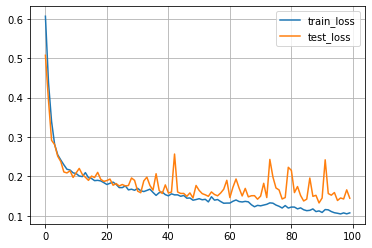

In [14]:
# plot the training and testing loss
plt.plot(hist['loss'], label='train_loss')
plt.plot(hist['test_loss'], label='test_loss')
plt.legend()
plt.grid()
plt.show()

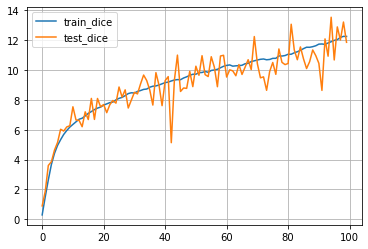

In [15]:
# plot the training and testing dice
plt.plot(hist['dice'], label='train_dice')
plt.plot(hist['test_dice'], label='test_dice')
plt.legend()
plt.grid()
plt.show()

In [16]:
sample_val_img, sample_val_mask = next(iter(dataloader['test']))
one_sample_img = sample_val_img[0]
one_sample_mask = sample_val_mask[0]
model.eval()
with torch.no_grad():
    output = model(one_sample_img.unsqueeze(0).to(device))[0]
    pred_mask = torch.argmax(output, axis=0)
    
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))
ax1.imshow(one_sample_img.permute(1, 2, 0).cpu().numpy())
ax1.set_title('Image')
ax2.imshow(torch.argmax(one_sample_mask, axis=0).cpu().numpy())
ax2.set_title('mask')
ax3.imshow(pred_mask.squeeze().cpu().numpy())
ax3.set_title('pred_mask')
plt.show()
print(f"output.shape = {output.shape}, pred_mask.shape = {pred_mask.shape}")

NameError: name 'one_sample_img' is not defined